## Normalize the point cloud data using the corresponding bounding box

Draw unnormalized points


<IPython.core.display.Javascript object>


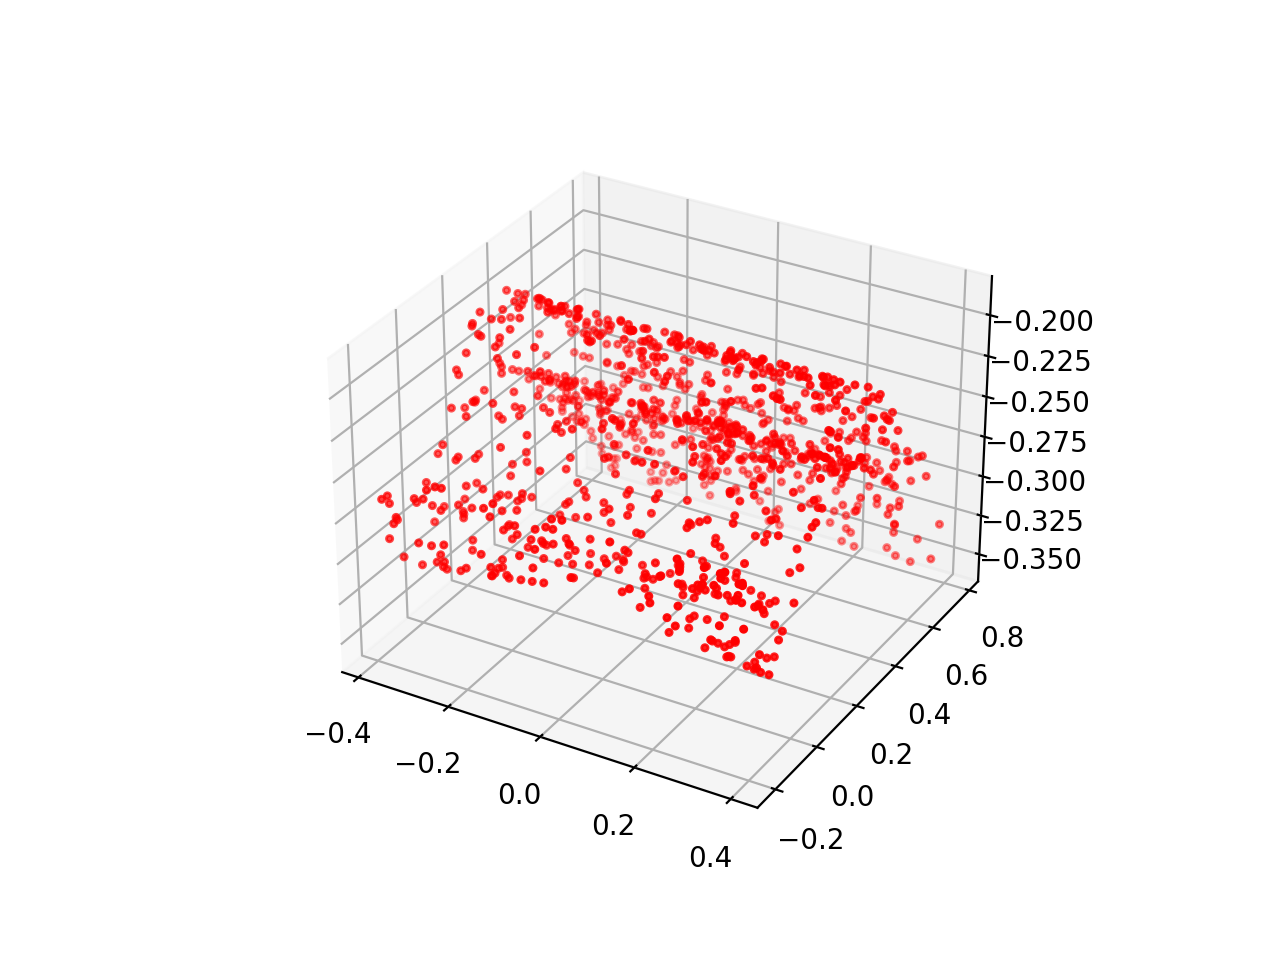

In [5]:
%matplotlib notebook

import os
import matplotlib
from data import PartNetDataset
from vis_utils import draw_partnet_objects
import matplotlib.pyplot as plt
from vis_utils import draw_geo

def _draw_geo(geo):
    fig = plt.figure(0)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    draw_geo(ax, geo, (1, 0, 0, 1))

# set dir
root_dir = '../../../data/partnethiergeo/chair_hier'
output_dir = '../../../data/normalized_chair_geo'
obj = PartNetDataset.load_object(os.path.join(root_dir, '179.json'), load_geo=True)
print('Draw unnormalized points')
node = obj.root.children[0]
_draw_geo(node.geo[0])

Draw normalized points


<ipython-input-7-00881086b00e>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  geo = quaternion_apply(quaternion_invert(torch.tensor(quat.q)), torch.tensor(geo)).data.numpy()


<IPython.core.display.Javascript object>


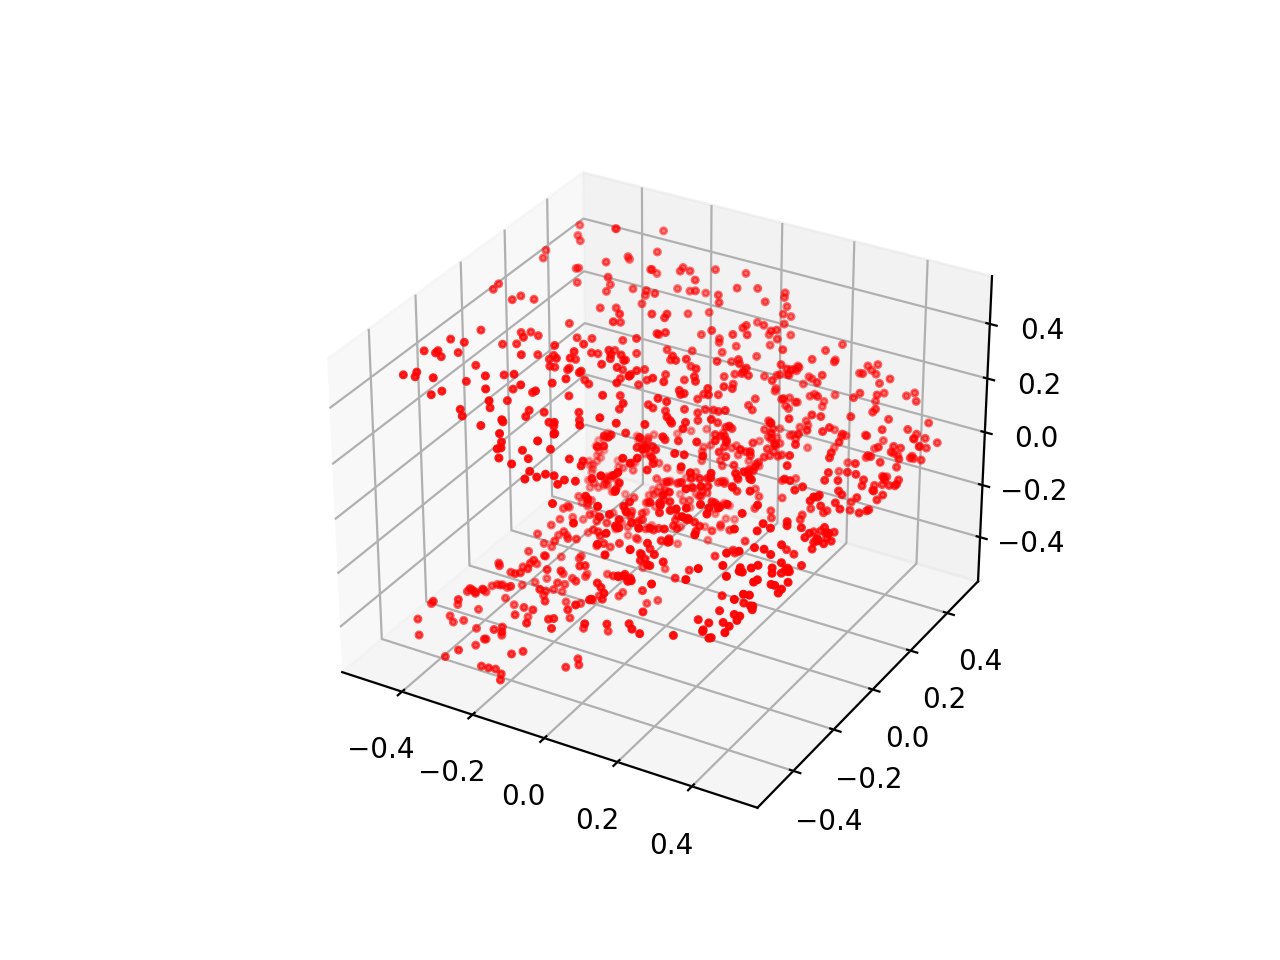

In [7]:
%matplotlib notebook
from pyquaternion import Quaternion
import numpy as np
import torch
from pytorch3d.transforms import quaternion_apply, quaternion_invert


def get_normalized_geo_and_box(node):
    box_quat = node.get_box_quat()[0]
    center = box_quat[:3].data.numpy()
    size = box_quat[3:6].data.numpy()
    quat = Quaternion(box_quat[6:].data.numpy())
    geo = node.geo[0]
    # translate
    geo = (geo - center[None])
    # rotate
    geo = np.array([quat.conjugate.rotate(g) for g in geo])
#     torch_geo = quaternion_apply(quaternion_invert(torch.tensor(quat.q)), torch.tensor(geo)).data.numpy()
    # scale
    geo = geo / size[None]
    return geo, box_quat.data.numpy()
    
normalized_geo, box_quat = get_normalized_geo_and_box(node)
# print(box_quat)
print('Draw normalized points')
_draw_geo(normalized_geo)



In [8]:
%matplotlib notebook
from tqdm import tqdm
import os, sys

output_dir = '../../../data/normalized_chair_geo'
os.makedirs(output_dir, exist_ok=True)

global counter
counter = 0

# read all data
obj_list = sorted([int(item.split('.')[0]) for item in os.listdir(root_dir) if item.endswith('.json')])

def get_normalized_parts_data(node, obj_id):
    global counter
    if node.is_leaf:
        normalized_geo, box_quat = get_normalized_geo_and_box(node)
        data = dict(
            normalized_geo=normalized_geo,
            box_quat=box_quat
        )
#         if np.max(np.abs(normalized_geo)) > 1:
#             print(np.max(np.abs(normalized_geo)))
#             _draw_geo(normalized_geo)
#             import pdb; pdb.set_trace()
        os.makedirs(os.path.join(output_dir, obj_id), exist_ok=True)
        fn = os.path.join(output_dir, obj_id, '{:06d}.npy'.format(counter))
        counter += 1
        np.save(fn, data)
    else:
        for child in node.children:
            get_normalized_parts_data(child, obj_id)

# visualize one data
for obj_name in tqdm(obj_list):
    obj = PartNetDataset.load_object(os.path.join(root_dir, str(obj_name)+'.json'), load_geo=True)
    # save leaves
    get_normalized_parts_data(obj.root, str(obj_name))

  0%|          | 0/8176 [00:00<?, ?it/s]<ipython-input-7-00881086b00e>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  geo = quaternion_apply(quaternion_invert(torch.tensor(quat.q)), torch.tensor(geo)).data.numpy()
  1%|          | 76/8176 [00:02<05:03, 26.73it/s]


KeyboardInterrupt: 